# lib import and data processing

In [ ]:
import pathlib
import imageio
import numpy as np
import torch
import torch.nn as nn
import torchvision
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import random
from skimage import io
from torchvision import transforms
import os
from torch.utils.data import Dataset, DataLoader
import cv2
#import google
import shutil
from sklearn.metrics import accuracy_score, recall_score, auc, roc_curve, precision_score
import warnings
warnings.filterwarnings('ignore')

#google.colab.drive.mount('/content/drive', force_remount=True)


# CHAGE YOUR PATH HERE
drive = pathlib.Path('./drive/MyDrive') / 'DLMI_Final/'
# data_2, data_3, thickened
database = drive/'Data/thickened'


Mounted at /content/drive


In [ ]:
# dataloader and initialization randomness
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(8)
torch.manual_seed(8);

# Dataset


In [ ]:
class CBCTdataset(Dataset):
    def __init__(self,
                 input_dir,
                 mode,
                 transform = None):

        self.mode = mode
        self.transform = transform
        try:
            if self.mode == 'train':
                self.data_dir = os.path.join(input_dir, 'train')
            elif self.mode == 'val':
                self.data_dir = os.path.join(input_dir, 'valid')
            elif self.mode == 'test':
                self.data_dir = os.path.join(input_dir, 'test')
        except ValueError:
            print('op should be either train, val or test!')

    def __len__(self):

        return len(os.listdir(f"{self.data_dir}/image"))

    def __getitem__(self,
                    idx):
        
        self.image_list, self.mask_list = self.get_data_name_list(self.data_dir)
        # self.image_name = self.image_list[idx].split('/')[-1]
        # self.mask_name = self.mask_list[idx].split('/')[-1]
        # print(self.image_list)

        # img = io.imread(self.image_list[idx])
        img = np.load(self.image_list[idx],allow_pickle=1)

        mask = np.load(self.mask_list[idx],allow_pickle=1)

        ## Transform image and mask
        if self.transform:
            img = self.normalize(img)
            if img.shape[0] == 5:
                img, mask = self.img_transform3d(img, mask)
            else:
                img, mask = self.img_transform(img, mask)
            # img = transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))(img)
  
        return img, mask

    def img_transform(self,
                      img,
                      mask):

        ## Apply Transformations to Image and Mask
        # 3 channel image for combine
        new_image = np.zeros((mask.shape[0],mask.shape[1], mask.shape[2]))
        for c in range(3):
            new_image[:,:,c] = img

        img = new_image
        # one-hot coding the mask for the 3 classes
        for c in range(3):
            mask[:,:,c] = mask[:,:,c] != 0

        img = img.astype(float).transpose(2,0,1)
        mask = mask.astype(float).transpose(2,0,1)
        
        img = torch.as_tensor(img.copy()).unsqueeze(0) 
        mask = torch.as_tensor(mask.copy()).unsqueeze(0)
        
        combined = torch.cat([img, mask], dim=0)


        combined = self.transform(combined)

        # Input is 3 channel or 1? now 3
        image2 = combined[0,0:3,:,:]

        mask2 = combined[1,0:3,:,:]
        img, mask = image2, mask2

        return img, mask

    def img_transform3d(self,
                      img,
                      mask):
        
        new_image = np.zeros((mask.shape[0],mask.shape[1], mask.shape[2],\
                              mask.shape[3]))
        for c in range(3):
            new_image[:,:,:,c] = img

        img = new_image
        # one-hot coding the mask for the 3 classes
        for c in range(3):
            mask[:,:,:,c] = mask[:,:,:,c] != 0

        img = img.astype(float).transpose(3,1,2,0)
        mask = mask.astype(float).transpose(3,1,2,0)
        
        img = torch.as_tensor(img.copy()).unsqueeze(0) 
        mask = torch.as_tensor(mask.copy()).unsqueeze(0)
        
        combined = torch.cat([img, mask], dim=0)
        new_combined = np.zeros([2,3,96,96,5])
        for sl in range(5):
            new_combined[:,:,:,:,sl] = self.transform(combined[:,:,:,:,sl])

        combined = new_combined
        # Input is 3 channel or 1? now 3
        image2 = combined[0,0:3,:,:,:]

        mask2 = combined[1,0:3,:,:,:]
        img, mask = image2, mask2

        return img, mask

    def get_data_name_list(self, data_dir):

        image_path = os.path.join(data_dir, 'image')
        mask_path = os.path.join(data_dir, 'label')

        image_list = [os.path.join(image_path, image) for image in sorted(os.listdir(image_path))]
        mask_list = [os.path.join(mask_path, mask) for mask in sorted(os.listdir(mask_path))]

        return image_list, mask_list 

    def normalize(self, img):
        return (img-img.min())/(img.max()-img.min())

# Network


### UNet

In [ ]:
# With nn.Upsample, nn.ReLU, 4 downsample and the bottleneck features = 1024
# More original one 
class UNet_v1(nn.Module):

    def __init__(self, nchannel=3, nclass=3):
        super().__init__()
        self.iput = self.conv(nchannel, 64)
        self.maxpool = torch.nn.MaxPool2d(2)
        self.enc1 = self.conv(64, 128)
        self.enc2 = self.conv(128, 256)
        self.enc3 = self.conv(256, 512)
        self.enc4 = self.conv(512, 1024 // 2)
        self.upsample = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = self.conv(1024, 512 // 2)
        self.dec2 = self.conv(512, 256 // 2)
        self.dec3 = self.conv(256, 128 // 2)
        self.dec4 = self.conv(128, 64)
        self.oput = torch.nn.Conv2d(64, nclass, kernel_size=1)

    def forward(self, x):
        x1 = self.iput(x)  # input
        # encoder layers
        x2 = self.maxpool(x1)
        x2 = self.enc1(x2)
        x3 = self.maxpool(x2)
        x3 = self.enc2(x3)
        x4 = self.maxpool(x3)
        x4 = self.enc3(x4)
        x5 = self.maxpool(x4)
        x5 = self.enc4(x5)
        # decoder layers with skip connections and attention gates
        x = self.upsample(x5)
        x = torch.cat([x, x4], dim=1)
        x = self.dec1(x)
        x = self.upsample(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec2(x)
        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec3(x)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec4(x)
        return self.oput(x)  # output

    def conv(self, in_channels, out_channels):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True))


### SCAUNet

In [ ]:
class Spatial_Attention_define(nn.Module):
    def __init__(self, num_channels):
        super(Spatial_Attention_define, self).__init__()

        self.conv = nn.Conv2d(3, 1, kernel_size=7, stride=1, padding=3)
        self.conv1 = nn.Conv2d(num_channels, 1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_conv1 = self.conv1(x)
        x = torch.cat([avg_out, max_out, x_conv1], dim=1)
        psi = self.conv(x)

        return psi

class Spatial_Attention_gate(nn.Module):
    def __init__(self, F_g, F_l):
        super(Spatial_Attention_gate, self).__init__()

        self.W_g = Spatial_Attention_define(num_channels=F_g)

        self.W_x = Spatial_Attention_define(num_channels=F_l)

        self.sigmoid = nn.Sigmoid()

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.sigmoid(g1 + x1)

        return psi
        
class AttU_Net_sAG(nn.Module):
    def __init__(self, nchannel=3, nclass=3):
        super(AttU_Net_sAG, self).__init__()
        self.iput = self.conv(nchannel, 64)
        self.maxpool = torch.nn.MaxPool2d(2)
        self.enc1 = self.conv(64, 128)
        self.enc2 = self.conv(128, 256)
        self.enc3 = self.conv(256, 512)
        self.enc4 = self.conv(512, 1024 // 2)
        self.upsample = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = self.conv(1024, 512 // 2)
        self.dec2 = self.conv(512, 256 // 2)
        self.dec3 = self.conv(256, 128 // 2)
        self.dec4 = self.conv(128, 64)
        self.oput = torch.nn.Conv2d(64, nclass, kernel_size=1)

        self.Spa5 = Spatial_Attention_gate(512, 512)
        self.Spa4 = Spatial_Attention_gate(256, 256)
        self.Spa3 = Spatial_Attention_gate(128, 128)
        self.Spa2 = Spatial_Attention_gate(64, 64)

    def forward(self, x):
        x1 = self.iput(x)  # input
        # encoder layers
        x2 = self.maxpool(x1)
        x2 = self.enc1(x2)
        x3 = self.maxpool(x2)
        x3 = self.enc2(x3)
        x4 = self.maxpool(x3)
        x4 = self.enc3(x4)
        x5 = self.maxpool(x4)
        x5 = self.enc4(x5)
        # decoder layers with skip connections and attention gates
        x = self.upsample(x5)
        s4 = self.Spa5(x, x4)
        x4 = x4 * s4
        x = torch.cat([x, x4], dim=1)

        x = self.dec1(x)
        x = self.upsample(x)
        s3 = self.Spa4(x, x3)
        x3 = x3 * s3
        x = torch.cat([x, x3], dim=1)

        x = self.dec2(x)
        x = self.upsample(x)
        s2 = self.Spa3(x, x2)
        x2 = x2 * s2
        x = torch.cat([x, x2], dim=1)

        x = self.dec3(x)
        x = self.upsample(x)
        s1 = self.Spa2(x, x1)
        x1 = x1 * s1
        x = torch.cat([x, x1], dim=1)

        x = self.dec4(x)
        return self.oput(x), s1  # output and attention map

    def conv(self, in_channels, out_channels):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True))
        

### 3d UNet


In [ ]:
# With nn.Upsample, nn.ReLU, 4 downsample and the bottleneck features = 1024
# More original one 
class UNet3d_v1(nn.Module):

    def __init__(self, nchannel=3, nclass=3):
        super().__init__()
        self.iput = self.conv(nchannel, 64)
        self.maxpool = torch.nn.MaxPool3d(kernel_size=(2,2,1),stride=(2,2,1))
        self.enc1 = self.conv(64, 128)
        self.enc2 = self.conv(128, 256)
        self.enc3 = self.conv(256, 512)
        self.enc4 = self.conv(512, 1024 // 2)

        self.upsample1 = nn.ConvTranspose3d(512, 512, 
                                           kernel_size=(2,2,1), stride=(2, 2, 1),
                                           padding=(0,0,0))
        self.upsample2 = nn.ConvTranspose3d(256, 256, 
                                    kernel_size=(2,2,1), stride=(2, 2, 1),
                                    padding=(0,0,0))
        self.upsample3 = nn.ConvTranspose3d(128, 128, 
                            kernel_size=(2,2,1), stride=(2, 2, 1),
                            padding=(0,0,0))
        self.upsample4 = nn.ConvTranspose3d(64, 64, 
                    kernel_size=(2,2,1), stride=(2, 2, 1),
                    padding=(0,0,0))
        
        # self.upsample = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = self.conv(1024, 512 // 2)
        self.dec2 = self.conv(512, 256 // 2)
        self.dec3 = self.conv(256, 128 // 2)
        self.dec4 = self.conv(128, 64)

        self.oput = torch.nn.Conv3d(64, nclass, kernel_size=1)

    def forward(self, x):
        x1 = self.iput(x)  # input
        # encoder layers
        x2 = self.maxpool(x1)
        x2 = self.enc1(x2)
        x3 = self.maxpool(x2)
        x3 = self.enc2(x3)
        x4 = self.maxpool(x3)
        x4 = self.enc3(x4)
        x5 = self.maxpool(x4)
        x5 = self.enc4(x5)
        # decoder layers with skip connections and attention gates
        x = self.upsample1(x5)
        x = torch.cat([x, x4], dim=1)
        x = self.dec1(x)
        x = self.upsample2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec2(x)
        x = self.upsample3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec3(x)
        x = self.upsample4(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec4(x)
        return self.oput(x)  # output

    def conv(self, in_channels, out_channels):
        return torch.nn.Sequential(
            torch.nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm3d(out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm3d(out_channels),
            torch.nn.ReLU(inplace=True))


# Dice Loss

In [ ]:
# square version
class BinearyDICELoss(nn.Module):
    def __init__(self):
        super(BinearyDICELoss, self).__init__()

    def forward(self, pred, target, smooth=1):
        # print(pred.shape)
        # print(pred.max(),pred.min())

        # print(pred.max(),pred.min())
        intersect = torch.mul(pred, target).sum(-1).sum(-1)
        denominator = (pred ** 2).sum(-1).sum(-1) + (target ** 2).sum(-1).sum(-1)
        dice_score = (2 * intersect + smooth) / (denominator + smooth)
        out = 1 - dice_score.mean()
        
        return out

class DICELoss(nn.Module):
    def __init__(self):
        super(DICELoss, self).__init__()

    def forward(self,pred, target):
        # pred = torch.sigmoid(pred)

        cl = target.shape[1]
        cost = BinearyDICELoss()
        loss = 0
        for i in range(cl):
            loss += cost(pred[:,i,:,:],target[:,i,:,:])
        loss /= cl
        return loss

# Train


In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=0, 
                 verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

        # if self.save_path:
        #   if not os.path.exists(self.save_path):
        #     os.mkdir(self.save_path)

    def __call__(self, save_path, epoch,loss_train,losses_val, val_loss, model):

        score = val_loss

        if self.best_score is None:
            self.best_score = score
            if save_path:
              self.save_checkpoint(save_path, epoch, loss_train, losses_val, val_loss, model)

        elif score >= self.best_score + self.delta:
            self.counter += 1
            # if self.counter % 1 == 0:
            #     print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            if save_path:
              # print('++++++++++saving model...++++++++++')
              self.save_checkpoint(save_path, epoch, loss_train,losses_val, val_loss, model)
            self.counter = 0

    def save_checkpoint(self, save_path, epoch, loss_train, losses_val, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print('=='*50)
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            print('=='*50)

        checkpoint = {
            'epoch': epoch,
            'model': model.state_dict(),
            'losses_train': loss_train,
            'losses_val': losses_val}
        torch.save(checkpoint, drive / save_path)

        self.val_loss_min = val_loss
        # print(f'saveing model done... validation loss is: {self.val_loss_min:.6f}')

### Train UNet

In [ ]:
early_stopping = EarlyStopping(patience=100, verbose=False)

def Train(model, path, num_epochs=500, bz = 5, lr = 0.01, display=False):
    # transforms.RandomCrop for small patches
    # Same seed for each experiments 
    random.seed(8)
    torch.manual_seed(8)
    img_transform = transforms.Compose([transforms.Resize([96,96]),
        transforms.RandomVerticalFlip(0.5),transforms.RandomHorizontalFlip(0),
        transforms.RandomRotation(90)
    ])

    # hyperparameters
    device = torch.device('cuda')
    train_batch_size = bz
    validation_batch_size = bz
    n_classes = 3 # binary mask
    model = model().to(device)
    learning_rate = lr

    ## Initialize Dataloaders
    train_dataset=CBCTdataset(input_dir=database, mode="train",transform=img_transform)
    validation_dataset=CBCTdataset(input_dir=database, mode="val",transform=img_transform)
    test_dataset=CBCTdataset(input_dir=database, mode="test",transform=img_transform)

    train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    ## Initialize Optimizer and Learning Rate Scheduler
    # optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    # loss function 
    cost_bce = nn.BCEWithLogitsLoss()
    cost_dice = DICELoss()
    
    losses_train = []
    losses_val = []
    print("Start Training...")
    ## Start training 
    for epoch in tqdm(range(num_epochs)):
        model.train()
        loss_train = 0
        loss_val = 0
        for image, mask in train_dataloader:
            image = image.float()
            mask = mask.float()
            if display:
              display_data(image,mask)
              break
            optimizer.zero_grad()
            predictions= model(image.to(device))

            # loss1 = cost_bce.forward(predictions,mask.to(device))
            loss2 = cost_dice.forward(predictions,mask.to(device))
            # loss = loss1 + loss2
            # print(loss1,loss2)

            loss2.backward()
            optimizer.step()
            loss_train += loss2.item()
        # scheduler.step()
        # loss for each batch 
        losses_train.append(loss_train/ len(train_dataloader))
        if (epoch+1) % 10 == 0:
            print(losses_train[-1])

    # validation loss
        with torch.no_grad():
          model.eval()
          predictions = []
          for image, mask in validation_dataloader:
              image = image.float()
              mask = mask.float()
              predictions = model(image.to(device))

              # loss1 = cost_bce.forward(predictions,mask.to(device))
              loss2 = cost_dice.forward(predictions,mask.to(device))
              # loss = loss1 + loss2
              loss_val += loss2.item()

          losses_val.append(loss_val/ len(validation_dataloader))

        early_stopping(path,epoch,losses_train,losses_val, loss_val/ len(validation_dataloader), model,
                       )
        if early_stopping.early_stop:
            print('++++++++++Early Stopping...++++++++++')
            break


### Train attUNet

In [ ]:
early_stopping = EarlyStopping(patience=100, verbose=False)

def Train_att(model, path, num_epochs=500, bz = 10, lr = 0.01, display=False):
    # transforms.RandomCrop for small patches
    # Same seed for each experiments 
    random.seed(8)
    torch.manual_seed(8)
    img_transform = transforms.Compose([transforms.Resize([96,96]),
        transforms.RandomVerticalFlip(0.5),transforms.RandomHorizontalFlip(0),
        transforms.RandomRotation(90)
    ])

    # hyperparameters
    device = torch.device('cuda')
    train_batch_size = bz
    validation_batch_size = bz
    n_classes = 3 # binary mask
    model = model().to(device)
    learning_rate = lr

    ## Initialize Dataloaders
    train_dataset=CBCTdataset(input_dir=database, mode="train",transform=img_transform)
    validation_dataset=CBCTdataset(input_dir=database, mode="val",transform=img_transform)
    test_dataset=CBCTdataset(input_dir=database, mode="test",transform=img_transform)

    train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    ## Initialize Optimizer and Learning Rate Scheduler
    # optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    # loss function 
    cost = nn.BCEWithLogitsLoss()
    # cost = DICELoss()

    losses_train = []
    losses_val = []
    print("Start Training...")
    ## Start training 
    for epoch in tqdm(range(num_epochs)):
        model.train()
        loss_train = 0
        loss_val = 0
        for image, mask in train_dataloader:
            image = image.float()
            mask = mask.float()
            if display:
              display_data(image,mask)
              break
            optimizer.zero_grad()
            predictions, att_map = model(image.to(device))

            loss = cost.forward(predictions,mask.to(device))
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        # scheduler.step()
        # loss for each batch 
        losses_train.append(loss_train/ len(train_dataloader))
        if (epoch+1) % 10 == 0:
            print(losses_train[-1])

    # validation loss
        with torch.no_grad():
          model.eval()
          predictions = []
          for image, mask in validation_dataloader:
              image = image.float()
              mask = mask.float()
              predictions,att_map = model(image.to(device))

              loss = cost.forward(predictions,mask.to(device))
              loss_val += loss.item()

          losses_val.append(loss_val/ len(validation_dataloader))

        early_stopping(path,epoch,losses_train,losses_val, loss_val/ len(validation_dataloader), model,
                       )
        if early_stopping.early_stop:
            print('++++++++++Early Stopping...++++++++++')
            break


In [ ]:
def display_data(image,mask):
    plt.imshow(image[0,:,:,:].numpy().transpose(1,2,0))
    plt.figure()
    plt.imshow(mask[0,:,:,:].numpy().transpose(1,2,0))
    plt.show()

### Train 3DUNet


In [ ]:
early_stopping = EarlyStopping(patience=100, verbose=False)

def Train_3DUNet(model, path, num_epochs=500, bz = 5, lr = 0.01, display=False):
    # transforms.RandomCrop for small patches
    # Same seed for each experiments 
    random.seed(8)
    torch.manual_seed(8)
    img_transform = transforms.Compose([transforms.Resize([96,96]),
        transforms.RandomVerticalFlip(0.5),transforms.RandomHorizontalFlip(0),
        transforms.RandomRotation(90)
    ])

    # hyperparameters
    device = torch.device('cuda')
    train_batch_size = bz
    validation_batch_size = bz
    n_classes = 3 # binary mask
    model = model().to(device)
    learning_rate = lr

    ## Initialize Dataloaders
    train_dataset=CBCTdataset(input_dir=database, mode="train",transform=img_transform)
    validation_dataset=CBCTdataset(input_dir=database, mode="val",transform=img_transform)
    test_dataset=CBCTdataset(input_dir=database, mode="test",transform=img_transform)

    train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    ## Initialize Optimizer and Learning Rate Scheduler
    # optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    # loss function 
    cost_bce = nn.BCEWithLogitsLoss()
    cost_dice = DICELoss()
    
    losses_train = []
    losses_val = []
    print("Start Training...")
    ## Start training 
    for epoch in tqdm(range(num_epochs)):
        model.train()
        loss_train = 0
        loss_val = 0
        for image, mask in train_dataloader:
            image = image.float()
            mask = mask.float()
            if display:
              display_data(image,mask)
              break
            optimizer.zero_grad()
            predictions= model(image.to(device))

            loss1 = cost_bce.forward(predictions,mask.to(device))
            # loss2 = cost_dice.forward(predictions,mask.to(device))
            # loss = loss1 + loss2
            # print(loss1,loss2)

            loss1.backward()
            optimizer.step()
            loss_train += loss1.item()
        # scheduler.step()
        # loss for each batch 
        losses_train.append(loss_train/ len(train_dataloader))
        if (epoch+1) % 10 == 0:
            print(losses_train[-1])

    # validation loss
        with torch.no_grad():
          model.eval()
          predictions = []
          for image, mask in validation_dataloader:
              image = image.float()
              mask = mask.float()
              predictions = model(image.to(device))

              loss1 = cost_bce.forward(predictions,mask.to(device))
              # loss2 = cost_dice.forward(predictions,mask.to(device))
              # loss = loss1 + loss2
              loss_val += loss1.item()

          losses_val.append(loss_val/ len(validation_dataloader))

        early_stopping(path,epoch,losses_train,losses_val, loss_val/ len(validation_dataloader), model,
                       )
        if early_stopping.early_stop:
            print('++++++++++Early Stopping...++++++++++')
            break


### Train 3DUNet_2D

In [ ]:
early_stopping = EarlyStopping(patience=100, verbose=False)

def Train_3DUNet_2D(model, path, num_epochs=500, bz = 5, lr = 0.01, display=False):
    # transforms.RandomCrop for small patches
    # Same seed for each experiments 
    random.seed(8)
    torch.manual_seed(8)
    img_transform = transforms.Compose([transforms.Resize([96,96]),
        transforms.RandomVerticalFlip(0.5),transforms.RandomHorizontalFlip(0),
        transforms.RandomRotation(90)
    ])

    # hyperparameters
    device = torch.device('cuda')
    train_batch_size = bz
    validation_batch_size = bz
    n_classes = 3 # binary mask
    model = model().to(device)
    learning_rate = lr

    ## Initialize Dataloaders
    train_dataset=CBCTdataset(input_dir=database, mode="train",transform=img_transform)
    validation_dataset=CBCTdataset(input_dir=database, mode="val",transform=img_transform)
    test_dataset=CBCTdataset(input_dir=database, mode="test",transform=img_transform)

    train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    ## Initialize Optimizer and Learning Rate Scheduler
    # optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    # loss function 
    cost_bce = nn.BCEWithLogitsLoss()
    cost_dice = DICELoss()
    
    losses_train = []
    losses_val = []
    print("Start Training...")
    ## Start training 
    for epoch in tqdm(range(num_epochs)):
        model.train()
        loss_train = 0
        loss_val = 0
        for image, mask in train_dataloader:
            image = image.float()
            mask = mask.float()
            if display:
              display_data(image,mask)
              break
            optimizer.zero_grad()
            predictions= model(image.to(device))

            loss1 = cost_bce.forward(predictions[:,:,:,:,2],mask[:,:,:,:,2].to(device))
            # loss2 = cost_dice.forward(predictions,mask.to(device))
            # loss = loss1 + loss2
            # print(loss1,loss2)

            loss1.backward()
            optimizer.step()
            loss_train += loss1.item()
        # scheduler.step()
        # loss for each batch 
        losses_train.append(loss_train/ len(train_dataloader))
        if (epoch+1) % 10 == 0:
            print(losses_train[-1])

    # validation loss
        with torch.no_grad():
          model.eval()
          predictions = []
          for image, mask in validation_dataloader:
              image = image.float()
              mask = mask.float()
              predictions = model(image.to(device))

              loss1 = cost_bce.forward(predictions[:,:,:,:,2],mask[:,:,:,:,2].to(device))
              # loss2 = cost_dice.forward(predictions,mask.to(device))
              # loss = loss1 + loss2
              loss_val += loss1.item()

          losses_val.append(loss_val/ len(validation_dataloader))

        early_stopping(path,epoch,losses_train,losses_val, loss_val/ len(validation_dataloader), model,
                       )
        if early_stopping.early_stop:
            print('++++++++++Early Stopping...++++++++++')
            break


# Evaluation


### Evalute UNet


In [ ]:
def normalize(img):
    return (img-img.min())/(img.max()-img.min())

def dice_score_image(prediction, target, n_classes):

    smooth = 1e-7
    dice_classes = np.zeros(n_classes)

    prediction = prediction.flatten(start_dim=2, end_dim=3)
    target = target.flatten(start_dim=2, end_dim=3)
    for cl in range(n_classes):

        TP = (prediction[:,cl,:]*target[:,cl,:]).sum(dim=1)
        DEN = (prediction[:,cl,:] + target[:,cl,:]).sum(dim = 1)

        dice_classes[cl] = ((2 * TP + smooth)/ (DEN+smooth)).mean()
    return dice_classes.mean()

def dice_score_dataset(model, dataloader, use_gpu=False):
    ## Number of Batches and Cache over Dataset
    n_batches = len(dataloader)
    scores = np.zeros(n_batches)
    ## Evaluate
    model.eval()
    idx = 0
    for data in dataloader:
        ## Format Data
        img, target = data
        img = img.float()
        target = target.float()
        if use_gpu:
            img = img.cuda()
            target = target.cuda()
        ## Make Predictions
        out = model(img)
        n_classes = out.shape[1]
        # prediction = torch.argmax(out, dim=1)
        # out = nn.Sigmoid()(out)
        out = normalize(out)

        prediction = out>0.5

        scores[idx] = dice_score_image(prediction, target, n_classes)
        idx += 1
    ## Average Dice Score Over Images

    m_dice = scores.mean()
    return m_dice



def evaluate(model, path, dataset, img_size = (96,96)):
    # without random crop to remove randomness
    img_transform = transforms.Compose([transforms.Resize(img_size),
        transforms.RandomVerticalFlip(0),transforms.RandomHorizontalFlip(0)
    ])

    device = torch.device('cuda')
    train_batch_size = 1
    validation_batch_size = 1

    ## Initialize Dataloaders
    train_dataset=CBCTdataset(input_dir=database, mode="train",transform=img_transform)
    validation_dataset=CBCTdataset(input_dir=database, mode="val",transform=img_transform)
    test_dataset=CBCTdataset(input_dir=database, mode="test",transform=img_transform)
    # shuffle = False for comparison
    train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
    validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    if dataset == 'train':
        dataloader = train_dataloader
    elif dataset == 'validation':
        dataloader = validation_dataloader
    else:
        dataloader = test_dataloader

    checkpoint = torch.load( drive / path)
    model_trained = model(nclass=3).to(device)
    model_trained.load_state_dict(checkpoint['model'])
    losses_train = checkpoint['losses_train']
    losses_val = checkpoint['losses_val']
    # print(model_pretrain.oput)
    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(losses_train, 'C0')
    ax.set_ylabel('Loss',fontsize = 18)
    # ax2 = ax.twinx()
    ax.plot(losses_val, 'C1')
    ax.legend(['Train loss','Validation loss'],fontsize = 16)
    # ax.set_ylabel('Validation Loss', c='C1', fontweight='bold')
    # ax2.spines['right'].set_position(('axes', 1 + 0.3))
    ax.set_xlabel('Epoch',fontsize = 18)
    ax.set_title('Losses w.r.t epoch',fontweight='bold', fontsize = 20)
    plt.show()

    nimages = 14
    fig, axs = plt.subplots(nrows=3, ncols=nimages, figsize=(nimages*3,3*3), subplot_kw={'xticks': [], 'yticks': []})
    axs[0,0].set_ylabel('image')
    axs[1,0].set_ylabel('mask')
    axs[2,0].set_ylabel('Prediction')

    prec_list_ = []
    acc_list_ = []
    recall_list_ = []
    auc_list_ = []
    i = 0
    with torch.no_grad():
        model_trained.eval()
        for images, masks in dataloader: 
            if i >= nimages:
                break
            images = images.float()
            masks = masks.float()
            predictions = model_trained(images.to(device))
            for image, mask, prediction in zip(images, masks, predictions):
                # if i >= nimages:
                #     break
                image = image.numpy().transpose(1,2,0)
                truth = mask.cpu().numpy().reshape([-1])
                truth_ = []
                truth_.append(mask[0,:,:].cpu().numpy().reshape([-1]))
                truth_.append(mask[1,:,:].cpu().numpy().reshape([-1]))
                truth_.append(mask[2,:,:].cpu().numpy().reshape([-1]))
                
                for idx,each in enumerate(truth_):
                    truth_[idx] = each.astype('uint8')

                truth = truth.astype('uint8')

                mask = mask.numpy().transpose(1,2,0)

                prediction = normalize(prediction)

                pred = prediction.cpu().numpy().reshape([-1])
                fpr, tpr, threshold = roc_curve(truth,pred,pos_label=1)
                auc_img = auc(fpr,tpr)

                rgb_prediction = np.zeros((prediction.shape[1],prediction.shape[2],3))
                for c in range(3):
                    rgb_prediction[:,:,c] = prediction.cpu().numpy()[c,:,:]>0.5

                ac = []
                pc = []
                rc = []
                for c in range(3):
                    pred_cut = rgb_prediction[:,:,c].reshape([-1])
                    ac.append(accuracy_score(truth_[c],pred_cut))
                    pc.append(precision_score(truth_[c],pred_cut))
                    rc.append(recall_score(truth_[c],pred_cut))
                # print(pc,rc)
                acc_img = np.mean(ac)
                precisions = np.mean(pc)
                recalls = np.mean(rc)


                prec_list_.append(precisions)
                recall_list_.append(recalls)
                acc_list_.append(acc_img)
                auc_list_.append(auc_img)

                axs[0,i].imshow(image)
                axs[1,i].imshow(mask)
                axs[2,i].imshow(rgb_prediction)
                i += 1

    #Dice Score
    mdice = dice_score_dataset(model_trained, train_dataloader, use_gpu=True)
    print('train_dice score',mdice)
    mdice = dice_score_dataset(model_trained, test_dataloader, use_gpu=True)
    print('test_dice score',mdice)

    print('precision of test set is ',np.mean(prec_list_))
    print('recall of test set is ',np.mean(recall_list_))
    print('accuracy of test set is ',np.mean(acc_list_))
    print('auc of test set is ',np.mean(auc_list_))


### Evaluate Att


In [ ]:
def normalize(img):
    return (img-img.min())/(img.max()-img.min())

def dice_score_image_att(prediction, target, n_classes):

    smooth = 1e-7
    dice_classes = np.zeros(n_classes)

    prediction = prediction.flatten(start_dim=2, end_dim=3)
    target = target.flatten(start_dim=2, end_dim=3)
    for cl in range(n_classes):

        TP = (prediction[:,cl,:]*target[:,cl,:]).sum(dim=1)
        DEN = (prediction[:,cl,:] + target[:,cl,:]).sum(dim = 1)

        dice_classes[cl] = ((2 * TP + smooth)/ (DEN+smooth)).mean()
    return dice_classes.mean()

def dice_score_dataset_att(model, dataloader, use_gpu=False):
    ## Number of Batches and Cache over Dataset
    n_batches = len(dataloader)
    scores = np.zeros(n_batches)
    ## Evaluate
    model.eval()
    idx = 0
    for data in dataloader:
        ## Format Data
        img, target = data
        img = img.float()
        target = target.float()
        if use_gpu:
            img = img.cuda()
            target = target.cuda()
        ## Make Predictions
        out,att_map = model(img)
        n_classes = out.shape[1]
        # prediction = torch.argmax(out, dim=1)
        # out = nn.Sigmoid()(out)
        out = normalize(out)

        prediction = out>0.5

        scores[idx] = dice_score_image(prediction, target, n_classes)
        idx += 1
    ## Average Dice Score Over Images

    m_dice = scores.mean()
    return m_dice



def evaluate_att(model, path, dataset, img_size = (96,96)):
    # without random crop to remove randomness
    img_transform = transforms.Compose([transforms.Resize(img_size),
        transforms.RandomVerticalFlip(0),transforms.RandomHorizontalFlip(0)
    ])

    device = torch.device('cuda')
    train_batch_size = 1
    validation_batch_size = 1

    ## Initialize Dataloaders
    train_dataset=CBCTdataset(input_dir=database, mode="train",transform=img_transform)
    validation_dataset=CBCTdataset(input_dir=database, mode="val",transform=img_transform)
    test_dataset=CBCTdataset(input_dir=database, mode="test",transform=img_transform)
    # shuffle = False for comparison
    train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
    validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    if dataset == 'train':
        dataloader = train_dataloader
    elif dataset == 'validation':
        dataloader = validation_dataloader
    else:
        dataloader = test_dataloader

    checkpoint = torch.load( drive / path)
    model_trained = model(nclass=3).to(device)
    model_trained.load_state_dict(checkpoint['model'])
    losses_train = checkpoint['losses_train']
    losses_val = checkpoint['losses_val']
    # print(model_pretrain.oput)
    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(losses_train, 'C0')
    ax.set_ylabel('Loss',fontsize = 18)
    # ax2 = ax.twinx()
    ax.plot(losses_val, 'C1')
    ax.legend(['Train loss','Validation loss'],fontsize = 16)
    # ax.set_ylabel('Validation Loss', c='C1', fontweight='bold')
    # ax2.spines['right'].set_position(('axes', 1 + 0.3))
    ax.set_xlabel('Epoch',fontsize = 18)
    ax.set_title('Losses w.r.t epoch',fontweight='bold', fontsize = 20)
    plt.show()

    nimages = 14
    fig, axs = plt.subplots(nrows=4, ncols=nimages, figsize=(nimages*3,3*3), subplot_kw={'xticks': [], 'yticks': []})
    axs[0,0].set_ylabel('image')
    axs[1,0].set_ylabel('mask')
    axs[2,0].set_ylabel('Prediction')
    axs[3,0].set_ylabel('Attention_map')

    prec_list_ = []
    acc_list_ = []
    recall_list_ = []
    auc_list_ = []
    i = 0
    with torch.no_grad():
        model_trained.eval()
        for images, masks in dataloader: 
            if i >= nimages:
                break
            images = images.float()
            masks = masks.float()
            predictions,att_maps = model_trained(images.to(device))
            for image, mask, prediction,att_map in zip(images, masks, predictions,att_maps):
                # if i >= nimages:
                #     break
                image = image.numpy().transpose(1,2,0)
                truth = mask.cpu().numpy().reshape([-1])
                truth_ = []
                truth_.append(mask[0,:,:].cpu().numpy().reshape([-1]))
                truth_.append(mask[1,:,:].cpu().numpy().reshape([-1]))
                truth_.append(mask[2,:,:].cpu().numpy().reshape([-1]))
                
                for idx,each in enumerate(truth_):
                    truth_[idx] = each.astype('uint8')

                truth = truth.astype('uint8')
                mask = mask.numpy().transpose(1,2,0)
                att_map = att_map.squeeze().cpu().detach().numpy()
                # att_map = att_map / att_map.max()

                prediction = normalize(prediction)
                pred = prediction.cpu().numpy().reshape([-1])
                fpr, tpr, threshold = roc_curve(truth,pred,pos_label=1)
                auc_img = auc(fpr,tpr)
                rgb_prediction = np.zeros((prediction.shape[1],prediction.shape[2],3))
                rgb_att_map = np.zeros((96,96,3))

                for c in range(3):
                    rgb_prediction[:,:,c] = prediction.cpu().numpy()[c,:,:]>0.5

                for j in range(3):
                    rgb_att_map[:,:,j] = att_map

                att_map_img = rgb_att_map*image
                att_map_img = (att_map_img-att_map_img.min())\
                /(att_map_img.max()-att_map_img.min())

                ac = []
                pc = []
                rc = []
                for c in range(3):
                    pred_cut = rgb_prediction[:,:,c].reshape([-1])
                    ac.append(accuracy_score(truth_[c],pred_cut))
                    pc.append(precision_score(truth_[c],pred_cut))
                    rc.append(recall_score(truth_[c],pred_cut))
                # print(pc,rc)
                acc_img = np.mean(ac)
                precisions = np.mean(pc)
                recalls = np.mean(rc)


                prec_list_.append(precisions)
                recall_list_.append(recalls)
                acc_list_.append(acc_img)
                auc_list_.append(auc_img)

                axs[0,i].imshow(image)
                axs[1,i].imshow(mask)
                axs[2,i].imshow(rgb_prediction)
                axs[3,i].imshow(att_map, cmap = 'coolwarm')
                # axs[3,i].imshow(att_map_img, cmap = 'coolwarm')


                i += 1

    #Dice Score
    mdice = dice_score_dataset_att(model_trained, train_dataloader, use_gpu=True)
    print('train_dice score',mdice)
    mdice = dice_score_dataset_att(model_trained, test_dataloader, use_gpu=True)
    print('test_dice score',mdice)

    print('precision of test set is ',np.mean(prec_list_))
    print('recall of test set is ',np.mean(recall_list_))
    print('accuracy of test set is ',np.mean(acc_list_))
    print('auc of test set is ',np.mean(auc_list_))


### Evaluate 3d

In [ ]:
def normalize(img):
    return (img-img.min())/(img.max()-img.min())

def dice_score_image(prediction, target, n_classes):

    smooth = 1e-7
    dice_classes = np.zeros(n_classes)
    
    prediction = prediction.flatten(start_dim=2, end_dim=3)
    target = target.flatten(start_dim=2, end_dim=3)
    for cl in range(n_classes):

        TP = (prediction[:,cl,:]*target[:,cl,:]).sum(dim=1)
        DEN = (prediction[:,cl,:] + target[:,cl,:]).sum(dim = 1)

        dice_classes[cl] = ((2 * TP + smooth)/ (DEN+smooth)).mean()
    return dice_classes.mean()

def dice_score_dataset(model, dataloader, use_gpu=False):
    ## Number of Batches and Cache over Dataset
    n_batches = len(dataloader)
    scores = np.zeros(n_batches)
    ## Evaluate
    model.eval()
    idx = 0
    for data in dataloader:
        ## Format Data
        img, target = data
        img = img.float()
        target = target.float()
        if use_gpu:
            img = img.cuda()
            target = target.cuda()
        ## Make Predictions
        out = model(img)
        n_classes = out.shape[1]
        # prediction = torch.argmax(out, dim=1)
        # out = nn.Sigmoid()(out)
        out = (out[:,:,:,:,2])

        prediction = out>0.5

        scores[idx] = dice_score_image(prediction, target[:,:,:,:,2], n_classes)
        idx += 1
    ## Average Dice Score Over Images

    m_dice = scores.mean()
    return m_dice



def evaluate_3d(model, path, dataset, img_size = (96,96)):
    # without random crop to remove randomness
    img_transform = transforms.Compose([transforms.Resize(img_size),
        transforms.RandomVerticalFlip(0),transforms.RandomHorizontalFlip(0)
    ])

    device = torch.device('cuda')
    train_batch_size = 1
    validation_batch_size = 1

    ## Initialize Dataloaders
    train_dataset=CBCTdataset(input_dir=database, mode="train",transform=img_transform)
    validation_dataset=CBCTdataset(input_dir=database, mode="val",transform=img_transform)
    test_dataset=CBCTdataset(input_dir=database, mode="test",transform=img_transform)
    # shuffle = False for comparison
    train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
    validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    if dataset == 'train':
        dataloader = train_dataloader
    elif dataset == 'validation':
        dataloader = validation_dataloader
    else:
        dataloader = test_dataloader

    checkpoint = torch.load( drive / path)
    model_trained = model(nclass=3).to(device)
    model_trained.load_state_dict(checkpoint['model'])
    losses_train = checkpoint['losses_train']
    losses_val = checkpoint['losses_val']
    # print(model_pretrain.oput)
    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(losses_train, 'C0')
    ax.set_ylabel('Loss',fontsize = 18)
    # ax2 = ax.twinx()
    ax.plot(losses_val, 'C1')
    ax.legend(['Train loss','Validation loss'],fontsize = 16)
    # ax.set_ylabel('Validation Loss', c='C1', fontweight='bold')
    # ax2.spines['right'].set_position(('axes', 1 + 0.3))
    ax.set_xlabel('Epoch',fontsize = 18)
    ax.set_title('Losses w.r.t epoch',fontweight='bold', fontsize = 20)
    plt.show()

    nimages = 14
    fig, axs = plt.subplots(nrows=3, ncols=nimages, figsize=(nimages*3,3*3), subplot_kw={'xticks': [], 'yticks': []})
    axs[0,0].set_ylabel('image')
    axs[1,0].set_ylabel('mask')
    axs[2,0].set_ylabel('Prediction')

    prec_list_ = []
    acc_list_ = []
    recall_list_ = []
    auc_list_ = []
    i = 0
    with torch.no_grad():
        model_trained.eval()
        for images, masks in dataloader: 
            if i >= nimages:
                break
            images = images.float()
            masks = masks.float()
            predictions = model_trained(images.to(device))
            for image, mask, prediction in zip(images, masks, predictions):
                # if i >= nimages:
                #     break
                image = image[:,:,:,2].numpy().transpose(1,2,0)
                truth = mask[:,:,:,2].cpu().numpy().reshape([-1])
                truth_ = []
                truth_.append(mask[0,:,:,2].cpu().numpy().reshape([-1]))
                truth_.append(mask[1,:,:,2].cpu().numpy().reshape([-1]))
                truth_.append(mask[2,:,:,2].cpu().numpy().reshape([-1]))
                
                for idx,each in enumerate(truth_):
                    truth_[idx] = each.astype('uint8')

                truth = truth.astype('uint8')

                mask = mask[:,:,:,2].numpy().transpose(1,2,0)

                # prediction = normalize(prediction[:,:,:,2])
                prediction = (prediction[:,:,:,2])


                pred = prediction.cpu().numpy().reshape([-1])
                fpr, tpr, threshold = roc_curve(truth,pred,pos_label=1)
                auc_img = auc(fpr,tpr)

                rgb_prediction = np.zeros((prediction.shape[1],prediction.shape[2],3))
                for c in range(3):
                    rgb_prediction[:,:,c] = prediction.cpu().numpy()[c,:,:]>0.5

                ac = []
                pc = []
                rc = []
                for c in range(3):
                    pred_cut = rgb_prediction[:,:,c].reshape([-1])
                    ac.append(accuracy_score(truth_[c],pred_cut))
                    pc.append(precision_score(truth_[c],pred_cut))
                    rc.append(recall_score(truth_[c],pred_cut))
                # print(pc,rc)
                acc_img = np.mean(ac)
                precisions = np.mean(pc)
                recalls = np.mean(rc)


                prec_list_.append(precisions)
                recall_list_.append(recalls)
                acc_list_.append(acc_img)
                auc_list_.append(auc_img)

                axs[0,i].imshow(image)
                axs[1,i].imshow(mask)
                axs[2,i].imshow(rgb_prediction)
                i += 1

    #Dice Score
    mdice = dice_score_dataset(model_trained, train_dataloader, use_gpu=True)
    print('train_dice score',mdice)
    mdice = dice_score_dataset(model_trained, test_dataloader, use_gpu=True)
    print('test_dice score',mdice)

    print('precision of test set is ',np.mean(prec_list_))
    print('recall of test set is ',np.mean(recall_list_))
    print('accuracy of test set is ',np.mean(acc_list_))
    print('auc of test set is ',np.mean(auc_list_))


### Evaluate 3d_2d


In [ ]:
def normalize(img):
    return (img-img.min())/(img.max()-img.min())

def dice_score_image(prediction, target, n_classes):

    smooth = 1e-7
    dice_classes = np.zeros(n_classes)
    
    prediction = prediction.flatten(start_dim=2, end_dim=3)
    target = target.flatten(start_dim=2, end_dim=3)
    for cl in range(n_classes):

        TP = (prediction[:,cl,:]*target[:,cl,:]).sum(dim=1)
        DEN = (prediction[:,cl,:] + target[:,cl,:]).sum(dim = 1)

        dice_classes[cl] = ((2 * TP + smooth)/ (DEN+smooth)).mean()
    return dice_classes.mean()

def dice_score_dataset(model, dataloader, use_gpu=False):
    ## Number of Batches and Cache over Dataset
    n_batches = len(dataloader)
    scores = np.zeros(n_batches)
    ## Evaluate
    model.eval()
    idx = 0
    for data in dataloader:
        ## Format Data
        img, target = data
        img = img.float()
        target = target.float()
        if use_gpu:
            img = img.cuda()
            target = target.cuda()
        ## Make Predictions
        out = model(img)
        n_classes = out.shape[1]
        # prediction = torch.argmax(out, dim=1)
        # out = nn.Sigmoid()(out)
        out = (out[:,:,:,:,2])

        prediction = out>0.5

        scores[idx] = dice_score_image(prediction, target[:,:,:,:,2], n_classes)
        idx += 1
    ## Average Dice Score Over Images

    m_dice = scores.mean()
    return m_dice



def evaluate_3d(model, path, dataset, img_size = (96,96)):
    # without random crop to remove randomness
    img_transform = transforms.Compose([transforms.Resize(img_size),
        transforms.RandomVerticalFlip(0),transforms.RandomHorizontalFlip(0)
    ])

    device = torch.device('cuda')
    train_batch_size = 1
    validation_batch_size = 1

    ## Initialize Dataloaders
    train_dataset=CBCTdataset(input_dir=database, mode="train",transform=img_transform)
    validation_dataset=CBCTdataset(input_dir=database, mode="val",transform=img_transform)
    test_dataset=CBCTdataset(input_dir=database, mode="test",transform=img_transform)
    # shuffle = False for comparison
    train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
    validation_dataloader = DataLoader(validation_dataset, batch_size=1, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    if dataset == 'train':
        dataloader = train_dataloader
    elif dataset == 'validation':
        dataloader = validation_dataloader
    else:
        dataloader = test_dataloader

    checkpoint = torch.load( drive / path)
    model_trained = model(nclass=3).to(device)
    model_trained.load_state_dict(checkpoint['model'])
    losses_train = checkpoint['losses_train']
    losses_val = checkpoint['losses_val']
    # print(model_pretrain.oput)
    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(losses_train, 'C0')
    ax.set_ylabel('Loss',fontsize = 18)
    # ax2 = ax.twinx()
    ax.plot(losses_val, 'C1')
    ax.legend(['Train loss','Validation loss'],fontsize = 16)
    # ax.set_ylabel('Validation Loss', c='C1', fontweight='bold')
    # ax2.spines['right'].set_position(('axes', 1 + 0.3))
    ax.set_xlabel('Epoch',fontsize = 18)
    ax.set_title('Losses w.r.t epoch',fontweight='bold', fontsize = 20)
    plt.show()

    nimages = 14
    fig, axs = plt.subplots(nrows=3, ncols=nimages, figsize=(nimages*3,3*3), subplot_kw={'xticks': [], 'yticks': []})
    axs[0,0].set_ylabel('image')
    axs[1,0].set_ylabel('mask')
    axs[2,0].set_ylabel('Prediction')

    prec_list_ = []
    acc_list_ = []
    recall_list_ = []
    auc_list_ = []
    i = 0
    with torch.no_grad():
        model_trained.eval()
        for images, masks in dataloader: 
            if i >= nimages:
                break
            images = images.float()
            masks = masks.float()
            predictions = model_trained(images.to(device))
            for image, mask, prediction in zip(images, masks, predictions):
                # if i >= nimages:
                #     break
                image = image[:,:,:,4].numpy().transpose(1,2,0)
                truth = mask[:,:,:,2].cpu().numpy().reshape([-1])
                truth_ = []
                truth_.append(mask[0,:,:,2].cpu().numpy().reshape([-1]))
                truth_.append(mask[1,:,:,2].cpu().numpy().reshape([-1]))
                truth_.append(mask[2,:,:,2].cpu().numpy().reshape([-1]))
                
                for idx,each in enumerate(truth_):
                    truth_[idx] = each.astype('uint8')

                truth = truth.astype('uint8')

                mask = mask[:,:,:,2].numpy().transpose(1,2,0)

                prediction = (prediction[:,:,:,2])

                pred = prediction.cpu().numpy().reshape([-1])
                fpr, tpr, threshold = roc_curve(truth,pred,pos_label=1)
                auc_img = auc(fpr,tpr)

                rgb_prediction = np.zeros((prediction.shape[1],prediction.shape[2],3))
                for c in range(3):
                    rgb_prediction[:,:,c] = prediction.cpu().numpy()[c,:,:]>0.5

                ac = []
                pc = []
                rc = []
                for c in range(3):
                    pred_cut = rgb_prediction[:,:,c].reshape([-1])
                    ac.append(accuracy_score(truth_[c],pred_cut))
                    pc.append(precision_score(truth_[c],pred_cut))
                    rc.append(recall_score(truth_[c],pred_cut))
                # print(pc,rc)
                acc_img = np.mean(ac)
                precisions = np.mean(pc)
                recalls = np.mean(rc)


                prec_list_.append(precisions)
                recall_list_.append(recalls)
                acc_list_.append(acc_img)
                auc_list_.append(auc_img)

                axs[0,i].imshow(image)
                axs[1,i].imshow(mask)
                axs[2,i].imshow(rgb_prediction)
                i += 1

    #Dice Score
    mdice = dice_score_dataset(model_trained, train_dataloader, use_gpu=True)
    print('train_dice score',mdice)
    mdice = dice_score_dataset(model_trained, test_dataloader, use_gpu=True)
    print('test_dice score',mdice)

    print('precision of test set is ',np.mean(prec_list_))
    print('recall of test set is ',np.mean(recall_list_))
    print('accuracy of test set is ',np.mean(acc_list_))
    print('auc of test set is ',np.mean(auc_list_))


# Experiment

In [ ]:
Train_3DUNet_2D(UNet3d_v1, 'result/UNet_3dunet2d.pth', bz = 5,lr = 0.01)

In [ ]:
Train_att(AttU_Net_sAG, 'result/Att_UNet1_5.pth', bz = 5,lr= 0.01)

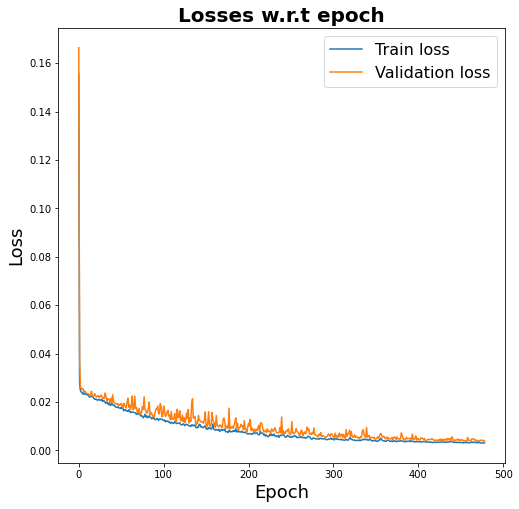

train_dice score 0.788920074694211
test_dice score 0.773718712470972
precision of test set is  0.7844588483322104
recall of test set is  0.7910247808308613
accuracy of test set is  0.9985558242394179
auc of test set is  0.9996691035518392


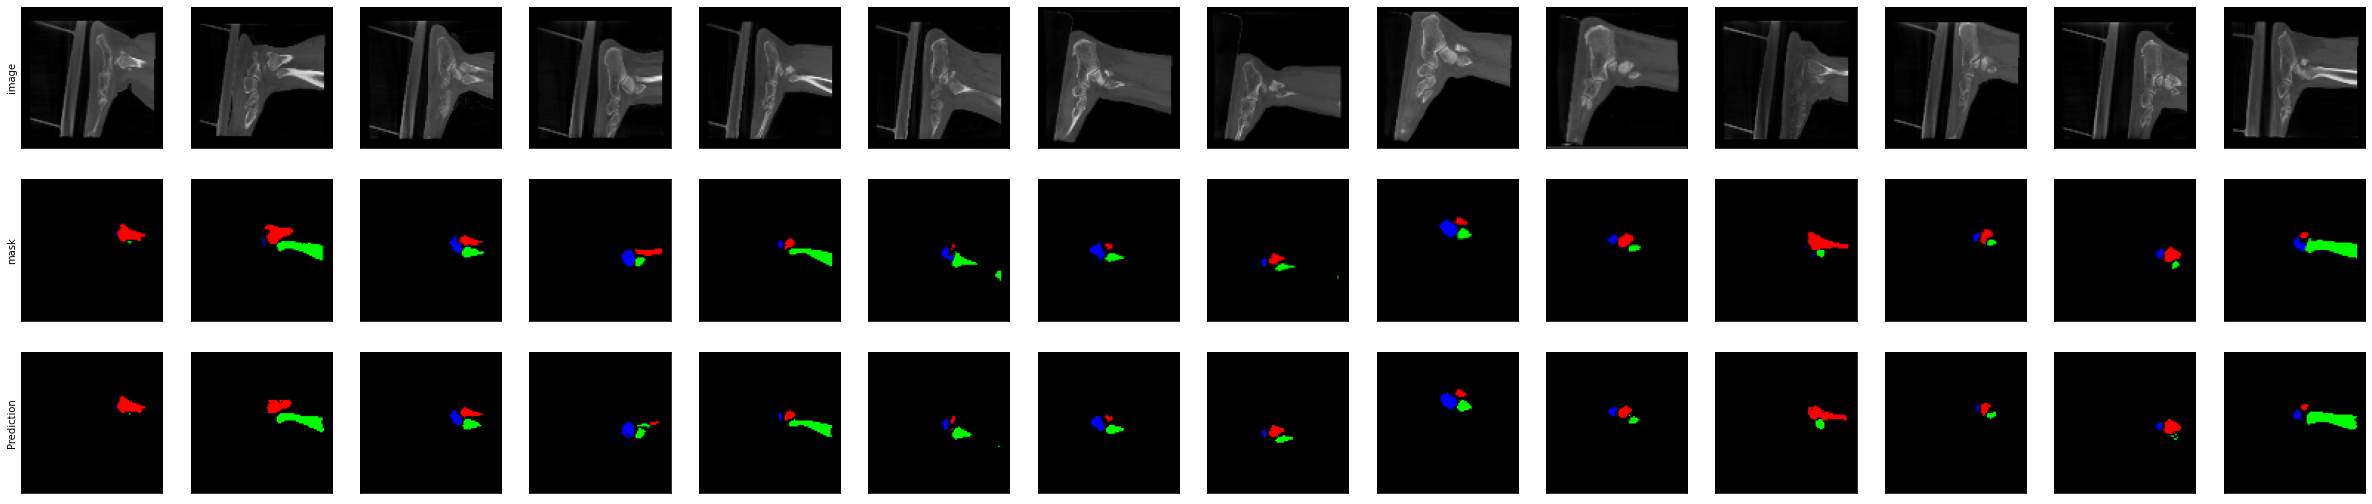

In [ ]:
# evaluate(UNet_v1, 'result/UNet_dice8_data2.pth',dataset='test')
evaluate_3d(UNet3d_v1, 'result/UNet_3dunet2d.pth',dataset='test')